In [1]:
"""
@author: Pearl Saldanha
"""

import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster
# import wta1d as wta1d
import os
os.environ["KAPOHOBAY"] = "1"

import wta1d as wta1d

def create_spikegen(net, indices, spiketimes, numPorts=None):
    """
    creates a spikegenerator from a list of indices with corresponding spiketimes
    :param net: the nx net in which the spikegen is created
    :param indices: the neuron indices that correspond to the spiketimes
    :param spiketimes: times at which the spikegen spikes
    :param numPorts: the numebr of spikegen neurons, if None, it is the max of indices
    :return: spikegenerator (needed to connect to other groups)
    """
    if numPorts is None:
        numPorts = np.max(indices)
    print('length of stimulation is', np.max(spiketimes), 'timesteps')
    spikegen = net.createSpikeGenProcess(numPorts=numPorts)
    for sg_neuron in np.unique(np.asarray(indices)):
        spikegen.addSpikes(spikeInputPortNodeIds=sg_neuron,
                           spikeTimes=list(spiketimes[np.where(indices == sg_neuron)]))
    return spikegen



In [2]:
net = nx.NxNet()

#ports
numNeurons=36
num_src=numNeurons
num_syn=num_src
num_recall = num_syn

spiketimes = np.asarray([5,6,8,9,10,11,12,1000,1001,1002,1003,1004,1005,1006]) 
indices =np.asarray([0]*len(spiketimes))

time_step = 1.00 #GLOBAL time step duration in milliseconds (spiking rate and time constant defined in MILLISECONDS)
simulated_time = 3000 #length of the simulation in milliseconds
sumulated_steps = int(simulated_time/time_step) #number of simulated steps
runtime = sumulated_steps

print("Length of 'indices' = ", len(indices))
print("Length of 'spiketime' = ", len(spiketimes))
print("Print-out of indices array: ", indices)

Length of 'indices' =  14
Length of 'spiketime' =  14
Print-out of indices array:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [3]:
com2 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synfire = net.createCompartmentGroup(size=numNeurons, prototype=com2)



#connection prototype
conn_proto_exc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY,
                                        weight=145,
                                        weightExponent=4,
                                        numWeightBits=6,
                                        enableDelay=1,
                                        numDelayBits =4,
                                        delay=14)
#connection mask                                     

conn_mask = np.zeros((num_src,num_src))
for i in range(num_src-1):
    #conn_mask[i,i+1]= 1
    conn_mask[i+1,i]= 1
    
# plt.imshow(conn_mask)

#compartment connections
exc_exc = synfire.connect(synfire, prototype=conn_proto_exc,connectionMask=conn_mask)

# =======================================================
# Creation of connections from spikeGen to synfire chain
# =======================================================

# Connection mask for the spikeGen
conn_mask_spikegen = np.zeros((num_src, num_src))
# conn_mask_spikegen[0,:] = 1  # Connects all spikeGen ports to only the first neuron in the synfire chain
conn_mask_spikegen[0,0] = 1  # Connects only the first port of the spikeGen to the first neuron in the synfire chain

# Draw excitatory connections from the spikeGen (using 'conn_mask_spikegen')
# sg = create_spikegen(net, indices, spiketimes, numPorts=num_src)

# spike_gen.connect(cx_grp,
#                   prototype=conn_proto,
#                   weight=np.ones((num_dst, num_src)) * int(weight_steps),
#                   delay=np.ones((num_dst, num_src)) * int(delay_steps),
#                   connectionMask=conn_mask)

# # Plot connection mask
# if plotConnMatrices or printConnMatrices:
#     print("Connection matrix for spike gen to synfire chain:")
# if plotConnMatrices:
#     plt.imshow(conn_mask_spikegen)
# if printConnMatrices:
#     print(conn_mask_spikegen)


# spike generator
sg = create_spikegen(net, indices, spiketimes, numPorts=num_src)
sg.connect(synfire,
           prototype=conn_proto_exc,
            connectionMask=conn_mask_spikegen)

length of stimulation is 1006 timesteps


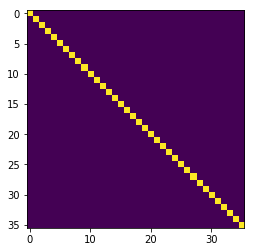

In [4]:
sr1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synrecall1 = net.createCompartmentGroup(size=num_recall, prototype=sr1)

conn_mask_recall = np.zeros((num_recall,num_syn))
for i in range(num_syn):
#     if i < num_recall:
        conn_mask_recall[i,i] = 1
plt.imshow(conn_mask_recall)       

#connection from synfire chain to the recall chain
syn_sr = synfire.connect(synrecall1, prototype=conn_proto_exc,connectionMask=conn_mask_recall)

In [5]:
# =======================================================
# WTA parameters
# =======================================================

wta_size = 24
sigma = 0.1 #1.4625#1.45#546#1.425
weight_max = 255 #150#120
weight_min_global = -0.01*weight_max #20
#weight_min_peak = -10.0*weight_max + shift#min weight in the negative peaks of the mexican hat function (DoG implementation)
syn_delay = 1
self_excitation = True
#input paramters
input_max_weight = 150#150

#---------------------------------------------------------------------------------------------------
#For the post synaptic traces to be
# updated we need to enable the back propagation of action potential whenever the compartment spikes.
# so we don't need that now
#---------------------------------------------------------------------------------------------------

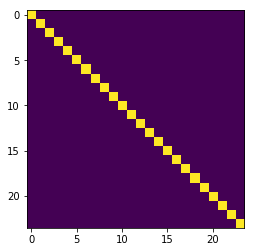

In [6]:
# =======================================================
# WTA compartment creation using the WTA1d module
# =======================================================


cx_proto = wta1d.create_compartment_prototype(time_step = time_step,
                                             tau_current_decay = 10,
                                             tau_voltage_decay = 150,#150,
                                             threshold_voltage_mant = 4000,# 3000, #*2^6
                                             min_voltage_exp = 16,#17,#-2^min_voltage_exp
                                             enable_backprop = True, #learning between wtas
#                                              enableSpikeBackprop = 1,
#                                              enableSpikeBackpropFromSelf = 1,
                                             logicalCoreId=1)

#create wta
wta = wta1d.WtaNet(net,wta_size,'mexican',sigma,0,weight_min_global,
                     weight_max,self_excitation,syn_delay,time_step,cx_proto)

wta.create()
# wta.print_parameters()
# print(wta.w_matrix)
plt.imshow(wta.w_matrix)

In [7]:
#TRAINING AND TESTING PARAMETERS

generalization_factor = 1


std_dev_teaching = 0#1.0*generalization_factor #1.5#2.0 #std dev teaching signal
weight_max_teaching = 240#150*1.5
weight_min_teaching = 1
weight_exponent_teaching = 2


In [8]:
# =======================================================
# WTA spike generator
# =======================================================

# Connection prototypes (not all used)
conn_proto_ex = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
connProtoInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)
connProtoMix = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

# Spike generator parameters
input_std_dev = std_dev_teaching  #1 #std dev in "neuron units", if set to 0, connections will become exaclty identity
input_max_weight = weight_max_teaching#240
input_min_weight = weight_min_teaching  #set to 0 for excitatory only connections
input_delay = 2


connProtoMixStrong = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED,enableLearning=0,weightExponent=weight_exponent_teaching)
#conect to readout layer (here readout layer)
# teaching_spike_gen = wta1d.create_wta_spike_gen(readout_size,time_step,input_weight_2_min,input_weight_2_max,input_delay_2,std_dev_teaching
#                                         ,readout_compartments,connProtoMixStrong,net,'gaussian')
# Create spike generator
teaching_spike_gen = wta1d.create_wta_spike_gen(wta_size,time_step,input_min_weight,input_max_weight,input_delay,input_std_dev
                                        ,wta.compartments,conn_proto_ex,net,'gaussian')

[[240.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1. 240.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1. 240.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1. 240.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1.   1. 240.   1.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1.   1.   1. 240.   1.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1.   1.   1.   1. 240.   1.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  1.   1.   1.   1.   1.   1.   1. 240.   1.   1.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]


In [9]:
#Spike generation and probes
"""
@authors: Davide Plozza, Damiano Steger
"""
import math

n_training_passes = 1 #how many cycles of training (during each cycle all training samples are exposed once, in the
                      # specified order)
generalization_factor = 1
training_sample_spacing = generalization_factor#2#3 #spacing between input sample "positions" in wta. It refers to the input samples if 
                    #use_inverse_for_training= False, else it refers to output injected samples
                    #it is the "generalization factor"
training_length = 1000
steps_per_wave = wta_size
n_waves_per_training_length = 2
n_training_samples = steps_per_wave * n_waves_per_training_length #wta_size//training_sample_spacing#(wta_size-2)//sample_spacing + 1

training_sample_duration = (training_length // n_waves_per_training_length) // steps_per_wave

training_sample_pause = 0 #pause in steps between training samples

waiting_steps = 1000 #pause between training and testing
ending_steps = waiting_steps//2 #pause at the end

#testing
test_length = 1000
steps_per_wave = wta_size
n_waves_per_training_length = 2
n_test_samples = steps_per_wave * n_waves_per_training_length
random_test_samples = False #random walk to test

test_sample_duration = (training_length // n_waves_per_training_length) // steps_per_wave #1200/ number of steps of exposure time for each training sample
test_sample_pause = 0

def func_to_learn(x):
    aux_x = np.fmod(x,steps_per_wave)
    return 12+6*np.sin(2*np.pi*(aux_x/steps_per_wave))

def map1d(x):
    return  int((func_to_learn(x)+0.5)%wta_size)#-1)%(wta_size-2)+1

def map1d_inv(y):
    return  int((func_to_learn_inv(y)+0.5)%wta_size)

#INPUT and TEACHING SIGNAL parameters

#Firing rate
firing_rate_input = 1000 #in hertz
firing_rate_teach = 1000 #firing rate teaching signal

min_firing_threshold = 1

#input
r_trials_input = 10#12 #order of the gamma distribution of the renewal process
std_dev_input = 1
backg_fr_input = 0#5 #background firing rate

#teaching signal
r_trials_teach = 10#12 #order of the gamma distribution of the renewal process
std_dev_teach = 1 #delta fuction
backg_fr_teach = 0 #background firing rate

#generate LIST of input vectors for plotting
#if watn to plot a vector only in a specific region, add an element to this list composed from 
#a tuple of two elements: timesteps and values. Use function "wta1d.add_plot_vector_costant"
input_vectors = []
teaching_vectors = []

#seed random gen
np.random.seed(1)


#generate spike list for all INPUT neurons
input_spikes = [np.array([0])]*wta_size 
#Firing rate
# firing_rate = 100#50 #in hertz

#firing_period = 1000/firing_rate #milliseconds
#period_steps = int(firing_period/time_step) #period between spikes (in hardware steps)

backg_fr = 0#5 #background firing rate

r_trials = 12
input_std_dev = 0#0.5
min_firing_threshold = 1


#INPUTS
#generate spike list for all INPUT neurons
input_spikes = [np.array([0])]*wta_size 

#generate LIST of input vectors
input_vectors = []

#seed random gen
np.random.seed(1)
training_cycle_steps = n_training_samples*training_sample_duration + (n_training_samples-1)*training_sample_pause
training_steps =training_cycle_steps*n_training_passes
sample_step = training_sample_spacing
training_start = 0
for x in range(n_training_samples):
            #if (x == 1): continue
            xin = x*sample_step+ 0.01
            wta1d.add_gaussian_input(map1d(xin),firing_rate_teach,backg_fr_teach,
                                     int((training_sample_duration+training_sample_pause)*x)+1,
                                     int((training_sample_duration+training_sample_pause)*x+training_sample_duration)+1,
                                    wta_size,input_spikes,time_step,r_trials_teach,std_dev_teach,min_firing_threshold,
                                    teaching_vectors)

#TESTS

#user defined test_steps = runtime-training_steps-waiting_steps#0.05*runtime
test_start = training_steps+waiting_steps#0.05*runtime
n_tests = n_test_samples#wta_size-2
margin_width = 1#width of "not usable" values at the margins of wta
test_steps = n_tests*test_sample_duration + (n_tests-1)*test_sample_pause
#test_duration = 1/n_tests #0.1 #duration of one learning sample, in %of total time
for x in range(0,n_tests):
    if random_test_samples:
        xTest = np.random.randint(margin_width,wta_size-margin_width)
    else:
#         xTest = x+margin_width
        xTest = x*sample_step+ 0.01
    #tests_spikes = np.arange(int(test_start+(test_sample_duration+test_sample_pause)*x)+1,
    #                         int(test_start+(test_sample_duration+test_sample_pause)*x+test_sample_duration)+1,
    #                         period_steps_1)
    #input_spikes[xTest] =np.append(input_spikes[xTest],tests_spikes)
    wta1d.add_gaussian_input(map1d(xTest),firing_rate_teach,backg_fr_teach,
                             int(test_start+(test_sample_duration+test_sample_pause)*x)+1,
                             int(test_start+(test_sample_duration+test_sample_pause)*x+test_sample_duration)+1,
                            wta_size,input_spikes,time_step,r_trials_input,std_dev_input,min_firing_threshold,
                            teaching_vectors)

input_spike_times = wta1d.add_spikes_to_gen(wta_size,input_spikes,teaching_spike_gen)

wta.create_probes(voltage_and_current=False)

{'sProbeWTA': <nxsdk.utils.plotutils.ProbeSet at 0x7f8e326b8b00>}

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.

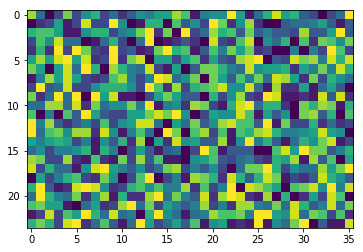

In [10]:
# =====================================================================
# Establishing learning rule between the synfire chain the WTA network
# =====================================================================


# x1Imp = 64#9#64# 20
# x1Tau = 10#90#10#50#25

# x2Imp = 10
# x2Tau = 90

# y1Imp = 10#64#40
# y1Tau = 90#10#25

# tEpoch = 4

x1Imp = 22#24#12#8#6#10 #32 #64#9#64# 20
x1Tau = 50#100#200#180 #25 #10#90#10#50#25  

# x2Imp = 10
# x2Tau = 90

y1Imp = 12#8
y1Tau = 4#5

tEpoch = 4


#use only x0 and y0 times a constant: dw = C*xo
#avg-dw-increase-per-time step will be C*avg-spiks-per-time-step = C*firing-rate

# Create an E-STDP learning rule used by the learning-enabled synapse and connect the pre synaptic spike generator.
lr = net.createLearningRule(#dw ='2^-6*(x1-4)*(128-w)*y0-2^-2*x0*', 
dt='u0*y1-u0*t', 
# dw = '2^-6*(x1-4)*(127-w)*y0-2^-2*x0',
dw = '2^-2*x1*y0 - 2^-2*y1*x0',
# dw = '2^-5*x1*(y1-12)*y0 - 2^-5*w*(y1-12)*y0',
#    dw='2^-5*x1*(y1-12)*y0', 
                            #dw = '2^-7*x1*y1*u1 - 2^-5*x1*u1',#dw = '2^3*x0*y0 - 2^-2*x0',#dw = '2^1*x0*y0 - 2^-5*x0 + 0*x1*x2*u0',#dw='-2^-2*x1*y0*sgn(w-50) - 2^-2*y1*x0',#dw='-2^-5*x1*y0*sgn(w-100) - 2^-5*x2*x0', #dw='-2^-4*w*u0', #dw='2^-2*x1*y0 - 2^-2*y1*x0',dw='2^-4*x1*y0 - 2^-7*x1*x0'
                            x1Impulse=x1Imp,
                            x1TimeConstant=x1Tau,
                            #x2Impulse=x2Imp,
                            #x2TimeConstant=x2Tau,
                            y1Impulse=y1Imp,
                            y1TimeConstant=y1Tau,
                            tEpoch=tEpoch)

#connection protoype with learning rule, excitatory only weights
conn_proto_lrn = nx.ConnectionPrototype(#weight=50,
                                        enableLearning=1,
                                        learningRule=lr,
                                        numTagBits=8,
                                        #weightLimitMant = 12,#144
                                        #weigthLimitExp = 2,
                                        signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)


# =======================================================
# Weight parameters for the learning rule
# =======================================================


max_plastic_weight = 15
random_plastic_weights = True
#initialize random or nonrandom connnections
max_weight = max_plastic_weight#10

if (random_plastic_weights):
    np.random.seed(0)
    w_matrix2=np.random.randint(0, max_weight, size=(wta_size,num_src))
else:
    w_matrix2=np.ones((wta_size,num_src))*max_weight
    for i in range(wta_size-1):
    #conn_mask[i,i+1]= 1
     w_matrix2[i,i]= 1
    
# d_matrix2=np.zeros((num_src,wta_size))
m_matrix2=np.ones((wta_size,num_src)) #np.ones(wta_size) #mask (all ones for now)

plt.imshow(w_matrix2)
#print(w_matrix2)#,m_matrix2,d_matrix2)
# print(m_matrix2)

# =======================================================
# Connect the synfire chain to the WTA compartments
# =======================================================


plastic_connections = synfire.connect(wta.compartments, 
                                     prototype=conn_proto_lrn,
                                     weight=w_matrix2,
#                                      delay=d_matrix2,
                                     connectionMask=m_matrix2)

print(m_matrix2)
# =======================================================
# Create weight probes to monitor the weight evolution
# =======================================================


#create synapse probes
connection_probes = {}
   #probes['wProbeNonLrn'] = connNonLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)
    
#set probeCOndition, for performance do NOT probe synapses too often (40x perdformance improvement)
weight_probe_start = 1
weight_probe_interval = 4
weight_probe_condition = nx.IntervalProbeCondition(dt=weight_probe_interval, tStart=weight_probe_start)
probe_list = plastic_connections.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])
#                                          nx.ProbeParameter.PRE_TRACE_X1,
#                                           nx.ProbeParameter.SYNAPSE_TAG]) #[:][0]

connection_probes['wProbe'] = [item[0] for item in probe_list]
# connection_probes['x1Probe'] = [item[1] for item in probe_list]
# connection_probes['y1Probe'] = [item[2] for item in probe_list]

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.

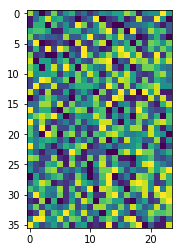

In [11]:
# Create an E-STDP learning rule used by the learning-enabled synapse and connect the pre synaptic spike generator.

x1Imp2 = 12#24#12#8#6#10 #32 #64#9#64# 20
x1Tau2 = 4#100#200#180 #25 #10#90#10#50#25

# x2Imp = 10
# x2Tau = 90

y1Imp2 =  22
y1Tau2 = 50

tEpoch2 = 4

lr2 = net.createLearningRule(#dw ='2^-6*(x1-4)*(128-w)*y0-2^-2*x0*', 
dt='u0*y1-u0*t', 
dw = '2^-2*x1*y0 - 2^-2*y1*x0',
# dw = '2^-5*x1*(y1-12)*y0 - 2^-5*w*(y1-12)*y0',
#    dw='2^-5*x1*(y1-12)*y0', 
                            #dw = '2^-7*x1*y1*u1 - 2^-5*x1*u1',#dw = '2^3*x0*y0 - 2^-2*x0',#dw = '2^1*x0*y0 - 2^-5*x0 + 0*x1*x2*u0',#dw='-2^-2*x1*y0*sgn(w-50) - 2^-2*y1*x0',#dw='-2^-5*x1*y0*sgn(w-100) - 2^-5*x2*x0', #dw='-2^-4*w*u0', #dw='2^-2*x1*y0 - 2^-2*y1*x0',dw='2^-4*x1*y0 - 2^-7*x1*x0'
                            x1Impulse=x1Imp2,
                            x1TimeConstant=x1Tau2,
                            #x2Impulse=x2Imp,
                            #x2TimeConstant=x2Tau,
                            y1Impulse=y1Imp2,
                            y1TimeConstant=y1Tau2,
                            tEpoch=tEpoch2)

#connection protoype with learning rule, excitatory only weights
conn_proto_lrn2 = nx.ConnectionPrototype(#weight=50,
                                        enableLearning=1,
                                        learningRule=lr2,
                                        numTagBits=8,
#                                         weightExponent = 4,
                                        #weightLimitMant = 12,#144
#                                         weigthLimitExp = 4,
                                        signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)


# =======================================================
# Weight parameters for the learning rule
# =======================================================


max_plastic_weight2 = 15
random_plastic_weights1 = True
#initialize random or nonrandom connnections
max_weight2 = max_plastic_weight2#10

if (random_plastic_weights1):
    np.random.seed(0)
    w_matrix2=np.random.randint(0, max_weight2, size=(num_syn,wta_size))
else:
    w_matrix2=np.ones((num_syn,wta_size))*max_weight2
    for i in range(wta_size-1):
    #conn_mask[i,i+1]= 1
     w_matrix2[i,i]= 1

# d_matrix2=np.zeros((num_src,wta_size))
m_matrix2=np.ones((num_syn,wta_size)) #np.ones(wta_size) #mask (all ones for now)

plt.imshow(w_matrix2)

#print(w_matrix2)#,m_matrix2,d_matrix2)
print(m_matrix2)

# =======================================================
# Connect the synfire chain to the WTA compartments
# =======================================================


plastic_connections2 = wta.compartments.connect(synrecall1, 
                                     prototype=conn_proto_lrn2,
                                     weight=w_matrix2,
#                                      delay=d_matrix2,
                                     connectionMask=m_matrix2)

# print(m_matrix2)
# =======================================================
# Create weight probes to monitor the weight evolution
# =======================================================


#create synapse probes
connection_probes2 = {}
   #probes['wProbeNonLrn'] = connNonLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)

#set probeCOndition, for performance do NOT probe synapses too often (40x perdformance improvement)
weight_probe_start2 = 1
weight_probe_interval2 = 4
weight_probe_condition2 = nx.IntervalProbeCondition(dt=weight_probe_interval2, tStart=weight_probe_start2)
probe_list_2 = plastic_connections2.probe([nx.ProbeParameter.SYNAPSE_WEIGHT,
                                         nx.ProbeParameter.PRE_TRACE_X1,
                                         nx.ProbeParameter.SYNAPSE_TAG]) #[:][0]

connection_probes2['wProbe2'] = [item[0] for item in probe_list_2]
connection_probes2['x1Probe2'] = [item[1] for item in probe_list_2]
connection_probes2['y1Probe2'] = [item[2] for item in probe_list_2]
#spike probe for recall chain




In [12]:
def extractStdpWeightChange(spikeTimesPre, spikeTimesPost, wProbeLrn):
    # Compute the weight changes for every weight change event
    w = np.array(connection_probes['wProbe'].data)
    wDiff = np.zeros(w.shape)
    wDiff[1:] = np.diff(w)

    wDiffNonZero = np.where(wDiff != 0)
    dw = wDiff[wDiffNonZero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(wProbeLrn.timeVector)
    tNonZero = time[wDiffNonZero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikeTimesPre = np.array(spikeTimesPre)
    spikeTimesPost = np.array(spikeTimesPost)
    dt = []
    for i in range(0, len(dw)):
        timeStamp = tNonZero[i]
        tPost = (spikeTimesPost[np.where(spikeTimesPost <= timeStamp)])[-1]
        tPre = (spikeTimesPre[np.where(spikeTimesPre <= timeStamp)])[-1]
        dt.append(tPost-tPre)
    dt, dw = extractStdpWeightChange(spikeTimesPre, actSpikeTimesPost,connection_probes['wProbe'])

    return dt, dw

In [13]:
#Add probes
s_probes = synfire.probe([nx.ProbeParameter.SPIKE])
(ur_probes, vr_probes, sr_probes) = synrecall1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                               nx.ProbeParameter.SPIKE])

# Create probes for WTA network
probes = wta.create_probes(voltage_and_current=False) 

In [14]:
net.run(runtime)
net.disconnect()


INFO:DRV:  Connecting to 127.0.0.1:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.04s)
INFO:DRV:      Processing probes... Done (0.09s)
INFO:DRV:      Writing modified registers... Done (0.03s)
INFO:DRV:      Initializing... Done (0.15s)
INFO:DRV:      Preparing input... Done (0.01s)
INFO:DRV:      Executing... Done (465.15s)
INFO:DRV:      Processing timeSeries... Done (49.81s)
INFO:DRV:  N2Driver: Finished (515.29s)


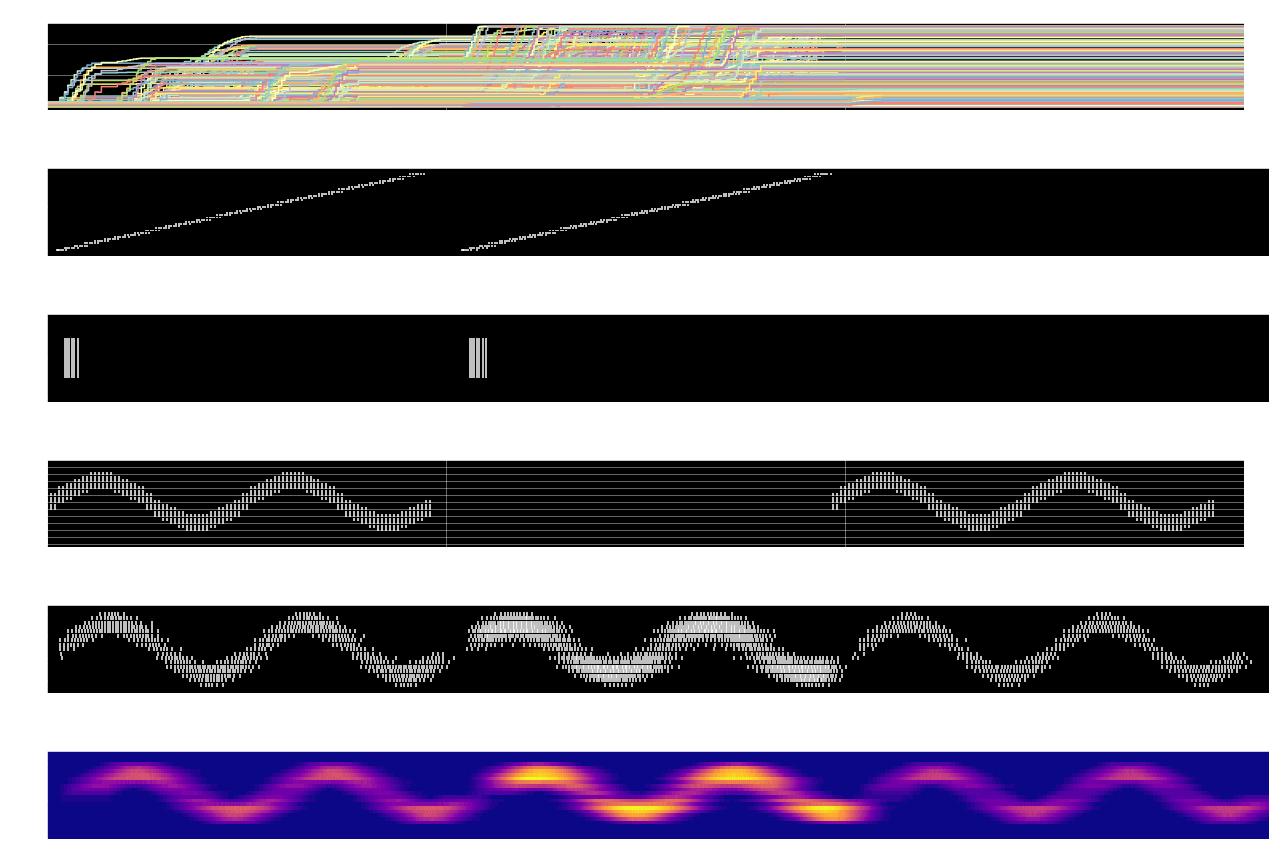

In [15]:
# =============
# Plot results
# =============

fig = plt.figure(1, figsize=(18,24))

plot_begin = 0
plot_end = runtime

n_plots = 12
i_plot = 1
time_tick_step = 1000
index_tick_step = 2
plt.style.use("dark_background") 

#colorbar size
cbar_fraction=0.01
cbar_pad=0.01
cmap = 'plasma'
#create fake image for fake colorbars
cbar_img = plt.imshow(np.zeros((1,1)))
# Plot synapse weights

plt.subplot(n_plots,1,i_plot)
wta1d.setup_spike_plot('Plastic connections weights',wta_size,plot_begin,plot_end,index_tick_step,False,
                 time_tick_step,cbar_img,cbar_fraction,cbar_pad)
for x in range(wta_size*wta_size):
    connection_probes['wProbe'][x].plot()
# ====================================================================================================================
s_probes[0]
# Plot output spikes of the synfire chain
i_plot += 1
plt.subplot(n_plots,1,i_plot)
syn = s_probes[0].plot() #colors=[h.get_color() for h in uh])
plt.xlim(plot_begin,plot_end)
plt.title('Spikes from synfire chain')

sr_probes[0]
# Plot output spikes of the synfire chain
i_plot += 1
plt.subplot(n_plots,1,i_plot)
syn = sr_probes[0].plot() #colors=[h.get_color() for h in uh])
plt.xlim(plot_begin,plot_end)
plt.title('Spikes from synfire chain')
# ====================================================================================================================

# Plot IPNUT spikes of WTA network
i_plot += 1
plt.subplot(n_plots,1,i_plot)
#ean_plot = wta1d.plot_input_vectors(teaching_vectors,'C1',0.25,5,"mean of the peaks")
sh = plotRaster(input_spike_times)
wta1d.setup_spike_plot("Teaching spike generator spikes",wta_size,plot_begin,plot_end,index_tick_step,True,
                       time_tick_step,cbar_img,cbar_fraction,cbar_pad)

# ====================================================================================================================
         
# Plot WTA spikes
i_plot += 1
plt.subplot(n_plots,1,i_plot)
probes['sProbeWTA'].plot()
plt.xlim(plot_begin,plot_end)
#plt.ylim(0,36)
plt.title('Output WTA spikes')

# ====================================================================================================================

# Plot WTA voltage
# i_plot += 1
# ax2 = plt.subplot(n_plots,1,i_plot)
# vh = probes['vProbeWTA'].plot()
# scale = 1
# plt.ylim(-2200*64*scale, 2200*64*scale)
# plt.xlim(plot_begin,plot_end)
# #plt.xlim(0,4000)
# plt.title('Output WTA voltage')

# ====================================================================================================================
         
# Plot WTA current
# i_plot += 1
# ax2 = plt.subplot(n_plots,1,i_plot)
# vh = probes['cProbeWTA'].plot()
# #scale = 1
# #plt.ylim(-2200*64*scale, 2200*64*scale)
# plt.xlim(plot_begin,plot_end)
# plt.title('OutputWTA current')


# ====================================================================================================================
         
#plot colormap firing rates
inst_firing_rate = wta1d.make_firing_rate_matrix(wta_size,plot_end,probes['sProbeWTA'],120)

i_plot += 1
ax = plt.subplot(n_plots,1,i_plot)
im = ax.imshow(inst_firing_rate,cmap = 'plasma', aspect='auto',zorder=-1,
                      origin='lower') #aspect='auto'
ax.set_title("WTA spike rates")


#plot max spiking rate WTA
# i_plot += 1
# max_rates = inst_firing_rate.max(0) #max operation on colums
# p = plt.subplot(n_plots,1,i_plot)
# plt.plot(max_rates)
# plt.xlim(plot_begin,plot_end)
# p.set_title("WTA peak firing rate")


#plot population vector (find peak position at very time step, by calculating expected value using normalized firing rate as weight)
# population_vector = wta1d.make_population_vector(wta_size,plot_end,inst_firing_rate)

# i_plot += 1
# p = plt.subplot(n_plots,1,i_plot)
# plt.plot(population_vector)
# #p.set_yticklabels(xticklabels, fontsize=7)
# plt.yticks(np.arange(0, 9, 1.0))
# plt.xlim(plot_begin,plot_end)
# p.set_title("WTA peak position")
# plt.grid(True)


plt.tight_layout()
plt.show()

# print("Spike counts:")
# totalCount = 0
# for neuron in range(num_dst):
#     spike_count = np.sum(s_probes[neuron].data)
#     totalCount += spike_count
#     print("    Neuron", str(neuron), ":", spike_count)
    
# print("Total spike count:", totalCount, "\n")

# print("Spike times for spike generator:")

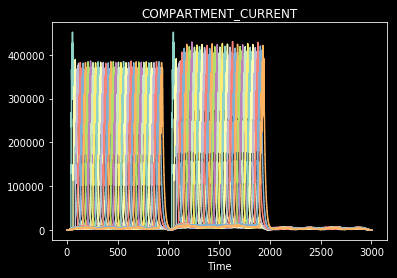

In [16]:
ur = ur_probes.plot()

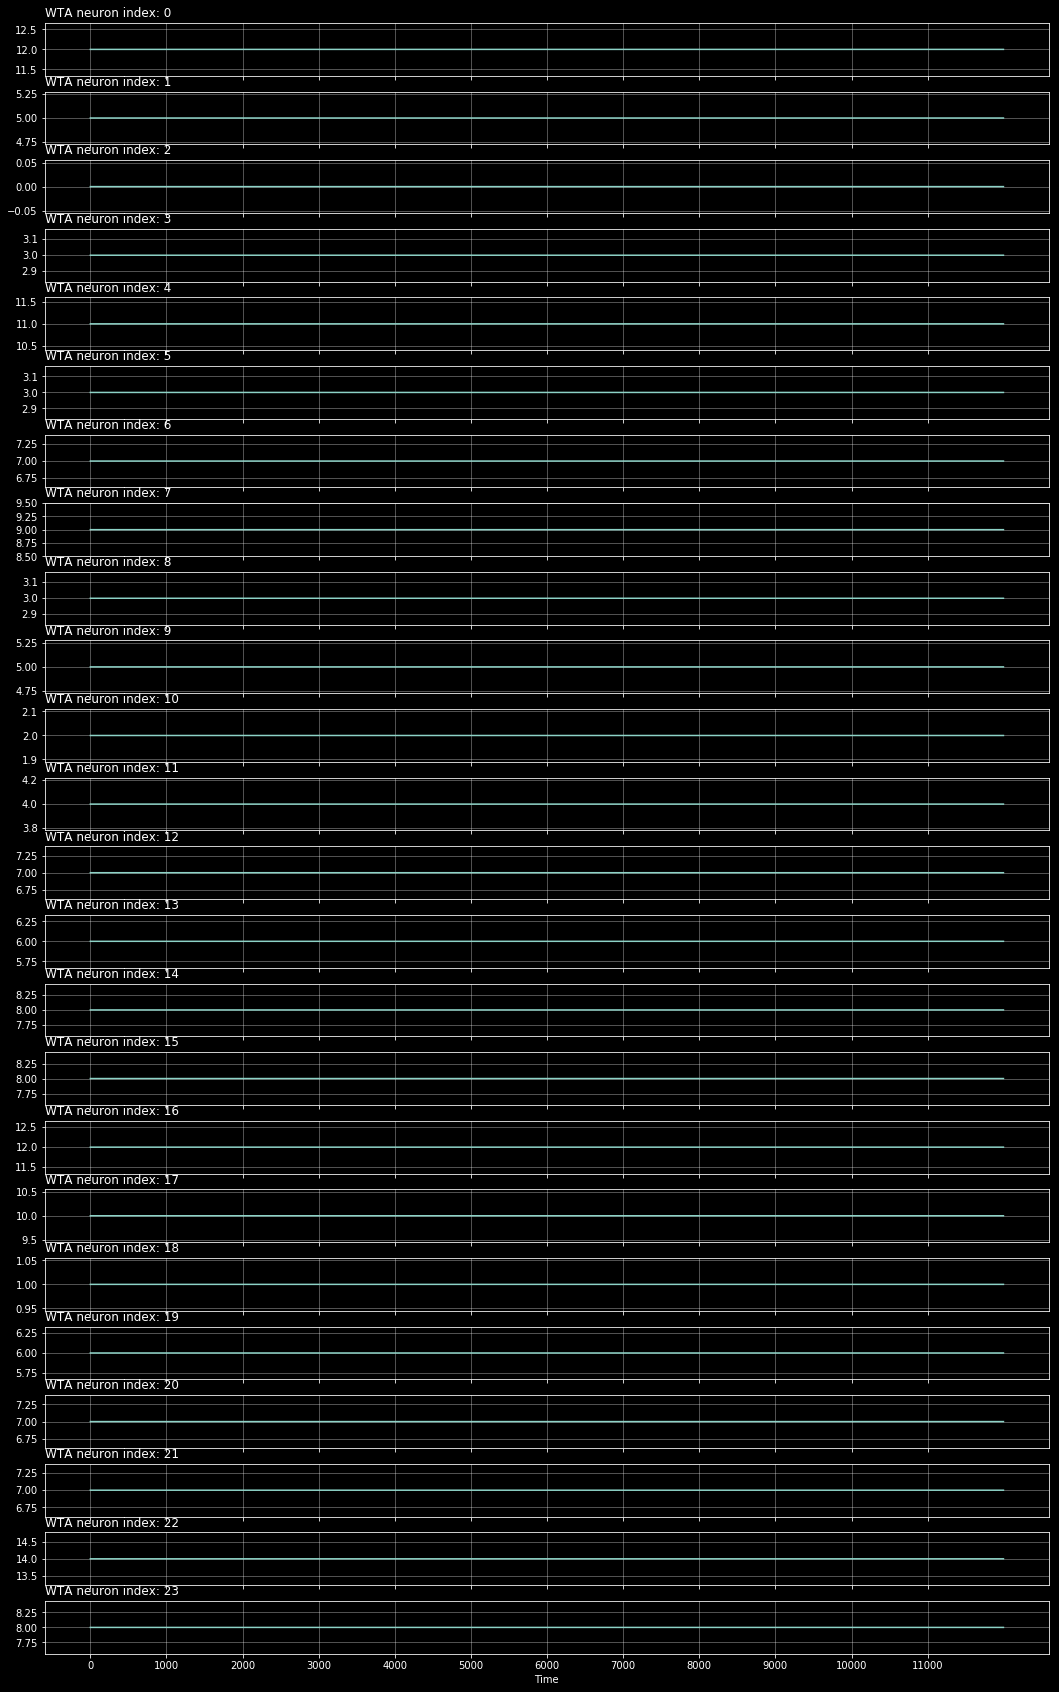

In [17]:
#connection_probes['x1Probe'] = [item[1] for item in probe_list]]
# plt.subplot(n_plots,1,i_plot)
fig = plt.figure(1, figsize=(18,30))
# wta1d.setup_spike_plot('Plastic connections weights',wta_size,plot_begin,plot_end,index_tick_step,False,
#                  time_tick_step,cbar_img,cbar_fraction,cbar_pad)
# #len(connection_probes['x1Probe'])
# w_range = np.arange(0,432,num_src,dtype=np.int)
# for x in enumerate(w_range):
#     plt.subplot(len(w_range),1,len(w_range+1)
# #     for i in range(len(connection_probes['wProbe']))
# #         connection_probes['wProbe'][x].plot()
# #                 plt.subplot(len(x_range),1,i+1)
#     plt.plot(connection_probes['wProbe'][x].data,label = 'w trace') 
x1_plot_begin = 0    
x1_plot_end = runtime 
x1_tick_step = time_tick_step//weight_probe_interval
w_range = np.arange(0,wta_size,dtype=np.int)
for i,x in enumerate(w_range):
    plt.subplot(len(w_range),1,i+1)
    plt.plot(connection_probes['wProbe'][x].data,label = 'weights') #plot()
#     plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['y1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [18]:
print("Spike counts:")
totalCount = 0
time = 900
for neuron in range(num_syn):
    spike_count = np.sum(s_probes[0].data)
    totalCount += spike_count
    print("    Neuron", str(neuron), ":", spike_count)
    
print("Total spike count:", totalCount, "\n")

# print("Spike times for spike generator:")
# print(spiketimes)

output_firingrate = totalCount/time
print("Average firing rate:")
print(output_firingrate)

output = np.where(s_probes[0].data)
print(output)

Spike counts:
    Neuron 0 : 468
    Neuron 1 : 468
    Neuron 2 : 468
    Neuron 3 : 468
    Neuron 4 : 468
    Neuron 5 : 468
    Neuron 6 : 468
    Neuron 7 : 468
    Neuron 8 : 468
    Neuron 9 : 468
    Neuron 10 : 468
    Neuron 11 : 468
    Neuron 12 : 468
    Neuron 13 : 468
    Neuron 14 : 468
    Neuron 15 : 468
    Neuron 16 : 468
    Neuron 17 : 468
    Neuron 18 : 468
    Neuron 19 : 468
    Neuron 20 : 468
    Neuron 21 : 468
    Neuron 22 : 468
    Neuron 23 : 468
    Neuron 24 : 468
    Neuron 25 : 468
    Neuron 26 : 468
    Neuron 27 : 468
    Neuron 28 : 468
    Neuron 29 : 468
    Neuron 30 : 468
    Neuron 31 : 468
    Neuron 32 : 468
    Neuron 33 : 468
    Neuron 34 : 468
    Neuron 35 : 468
Total spike count: 16848 

Average firing rate:
18.72
(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 

In [19]:
print("Spike counts:")
totalCount = 0
time = 1000
for neuron in range(wta_size):
    spike_count = np.sum(probes['sProbeWTA'][neuron].data)
    totalCount += spike_count
    print("    Neuron", str(neuron), ":", spike_count)
    
print("Total spike count:", totalCount, "\n")

# print("Spike times for spike generator:")
# print(input_spike_times)

output_firingrate = totalCount/time
print("Average firing rate:")
print(output_firingrate)


Spike counts:
    Neuron 0 : 0
    Neuron 1 : 0
    Neuron 2 : 0
    Neuron 3 : 0
    Neuron 4 : 37
    Neuron 5 : 99
    Neuron 6 : 138
    Neuron 7 : 183
    Neuron 8 : 232
    Neuron 9 : 154
    Neuron 10 : 158
    Neuron 11 : 82
    Neuron 12 : 97
    Neuron 13 : 108
    Neuron 14 : 157
    Neuron 15 : 169
    Neuron 16 : 235
    Neuron 17 : 190
    Neuron 18 : 151
    Neuron 19 : 105
    Neuron 20 : 44
    Neuron 21 : 0
    Neuron 22 : 0
    Neuron 23 : 0
Total spike count: 2339 

Average firing rate:
2.339


In [20]:
def plotStdpDynamics(timeDelta, weightDeltas):
    plt.figure(3, figsize=(9,5))
    
    plt.scatter(timeDelta, weightDeltas)
    plt.title('STDP weight change')
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
        
    plt.tight_layout()
    plt.show()
    
plotStdpDynamics(dt, dw)

NameError: name 'dt' is not defined

In [ ]:
print()

In [ ]:
probedata = []
for probe in connection_probes['wProbe']:
    probedata.append(probe.data)
    
    
np.array(probedata).shape

plt.plot(np.array(probedata)[:,-1])

plt.figure()
plt.imshow(np.reshape(np.array(probedata)[:,-1],(wta_size,num_src)))

In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,30))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval
time_tick_step = 1000
# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
num_plots = 36 #len(connection_probes['x1Probe'])
for x in range(num_plots):
    plt.subplot(num_plots,1,x+1)
    plt.plot(connection_probes2['x1Probe2'][x].data,label = 'x1 trace') #plot()
#     plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['x1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,24))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval
time_tick_step = 1000
# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
x_range = np.arange(0,432,num_src,dtype=np.int)
for i,x in enumerate(x_range):
    plt.subplot(len(x_range),1,i+1)
    plt.plot(connection_probes2['y1Probe2'][x].data,label = 'y1 trace') #plot()
#     plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['y1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()